In [449]:
# Titanic Machine Learning challenge

# Logistic regression - take 2 (use technical solutions from bryan p holman for data prep)
# https://www.kaggle.com/soham1024/titanic-data-science-eda-with-meme-solution

# 1. Contemplate the problem
# 2. Get training and test dataets, combine to one
# 3. Clean and prepare data 
# 4. Analyze, identify patterns, and explore the data.
# 5. Model, predict and solve the problem.


In [450]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import statsmodels.api as sm #Not used since I got error. Has better model diagnostics though

In [451]:
train = pd.read_csv("D:\\Datasets\\Titanic Machine Learning from Disaster\\kaggle datasets\\train.csv")
test = pd.read_csv("D:\\Datasets\\Titanic Machine Learning from Disaster\\kaggle datasets\\test.csv")
df_full = pd.concat([train, test], axis=0, ignore_index=True)

In [452]:
df_full.info() #Fare and Age are missing values. Cabin not considered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


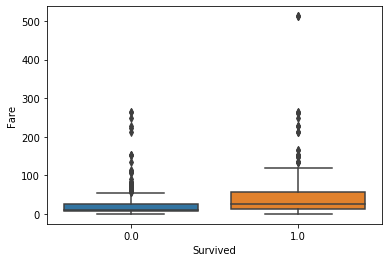

In [453]:
sns.boxplot(y=df_full["Fare"], x=df_full["Survived"] )

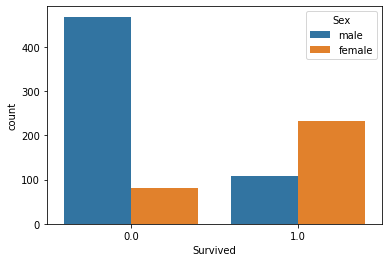

In [454]:
sns.countplot(hue=df_full["Sex"], x=df_full["Survived"])

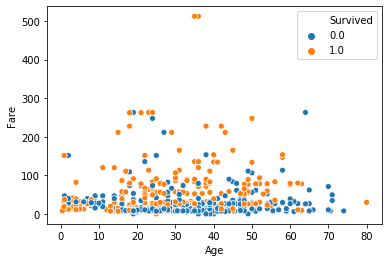

In [455]:
sns.scatterplot(df_full["Age"], df_full["Fare"], hue=df_full["Survived"])

In [456]:
#Clean and prepare data

# Impute missing values

df_full.groupby("Pclass").mean()["Age"]

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [457]:
def AgeImputor(columns):
    Age = columns[0]
    Pclass = columns[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 39.16
        elif Pclass == 2:
            return 29.51
        else:
            return 24.82
    else:
        return Age

df_full["Age"] = df_full[["Age", "Pclass"]].apply(AgeImputor, axis=1)

In [458]:
df_full.groupby("Pclass").mean()["Fare"]

Pclass
1    87.508992
2    21.179196
3    13.302889
Name: Fare, dtype: float64

In [459]:
df_full[df_full["Fare"].isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1043  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1043       3  male      0       NaN   3701

In [460]:
df_full.loc[df_full["PassengerId"] == 1044 , 'Fare'] = 13.3028
df_full[df_full["Fare"].isnull()]

Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket]
Index: []

In [461]:

df_full.loc[df_full["PassengerId"].isin([62, 830]), "Embarked"] = "C"

In [462]:
# Construct features

sex = pd.get_dummies(df_full["Sex"], drop_first=True)
embark = pd.get_dummies(df_full["Embarked"], drop_first=True)

In [463]:

df_full = pd.concat([df_full, sex, embark], axis=1)
df_full.drop([ 'Sex', 'Embarked'], axis=1, inplace=True)

In [464]:
df_full.drop([ 'Name'], axis=1, inplace=True)

In [465]:
df_full.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [466]:
df_full.head()

Age     Fare  Parch  PassengerId  Pclass  SibSp  Survived  male  Q  S
0  22.0   7.2500      0            1       3      1       0.0     1  0  1
1  38.0  71.2833      0            2       1      1       1.0     0  0  0
2  26.0   7.9250      0            3       3      0       1.0     0  0  1
3  35.0  53.1000      0            4       1      1       1.0     0  0  1
4  35.0   8.0500      0            5       3      0       0.0     1  0  1

In [467]:
df_full.corr()

Age      Fare     Parch  PassengerId    Pclass     SibSp  \
Age          1.000000  0.198334 -0.131213     0.019419 -0.443594 -0.198887   
Fare         0.198334  1.000000  0.221641     0.031110 -0.558694  0.160357   
Parch       -0.131213  0.221641  1.000000     0.008942  0.018322  0.373587   
PassengerId  0.019419  0.031110  0.008942     1.000000 -0.038354 -0.055224   
Pclass      -0.443594 -0.558694  0.018322    -0.038354  1.000000  0.060832   
SibSp       -0.198887  0.160357  0.373587    -0.055224  0.060832  1.000000   
Survived    -0.048926  0.257307  0.081629    -0.005007 -0.338481 -0.035322   
male         0.053277 -0.185693 -0.213125     0.013406  0.124617 -0.109609   
Q           -0.071262 -0.129952 -0.100943     0.011585  0.230491 -0.048678   
S           -0.032862 -0.172839  0.073258    -0.047923  0.096335  0.075198   

             Survived      male         Q         S  
Age         -0.048926  0.053277 -0.071262 -0.032862  
Fare         0.257307 -0.185693 -0.129952 -0.172839  
Parch        0.081629 -0.213125 -0.100943  0.073258  
PassengerId -0.005007  0.013406  0.011585 -0.047923  
Pclass      -0.338481  0.124617  0.230491  0.096335  
SibSp       -0.035322 -0.109609 -0.048678  0.075198  
Survived     1.000000 -0.543351  0.003650 -0.155660  
male        -0.543351  1.000000 -0.088651  0.119504  
Q            0.003650 -0.088651  1.000000 -0.489874  
S           -0.155660  0.119504 -0.489874  1.000000

In [468]:
df_full.describe()

Age         Fare        Parch  PassengerId       Pclass  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.348839    33.280206     0.385027   655.000000     2.294882   
std      13.127653    51.741830     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      22.000000     7.895800     0.000000   328.000000     2.000000   
50%      26.000000    14.454200     0.000000   655.000000     3.000000   
75%      37.000000    31.275000     0.000000   982.000000     3.000000   
max      80.000000   512.329200     9.000000  1309.000000     3.000000   

             SibSp    Survived         male            Q            S  
count  1309.000000  891.000000  1309.000000  1309.000000  1309.000000  
mean      0.498854    0.383838     0.644003     0.093965     0.698243  
std       1.041658    0.486592     0.478997     0.291891     0.459196  
min       0.000000    0.000000     0.000000     0.000000     0.000000  
25%       0.000000    0.000000     0.000000     0.000000     0.000000  
50%       0.000000    0.000000     1.000000     0.000000     1.000000  
75%       1.000000    1.000000     1.000000     0.000000     1.000000  
max       8.000000    1.000000     1.000000     1.000000     1.000000

In [469]:
df_full.loc[df_full["Fare"] <= 0, "Fare"] = 0.5

In [470]:
df_full["Age_trans"] = df_full["Age"] ** 2
df_full["Fare_trans"] = df_full["Fare"] ** 2
df_full["Age_trans2"] = df_full["Age"] ** .5
df_full["Fare_trans2"] = df_full["Fare"] ** .5
df_full["Age_trans3"] = df_full["Age"] ** -1
df_full["Fare_trans3"] = df_full["Fare"] ** -1

In [471]:
df_full.corr()

Age      Fare     Parch  PassengerId    Pclass     SibSp  \
Age          1.000000  0.198401 -0.131213     0.019419 -0.443594 -0.198887   
Fare         0.198401  1.000000  0.221603     0.031094 -0.558810  0.160309   
Parch       -0.131213  0.221603  1.000000     0.008942  0.018322  0.373587   
PassengerId  0.019419  0.031094  0.008942     1.000000 -0.038354 -0.055224   
Pclass      -0.443594 -0.558810  0.018322    -0.038354  1.000000  0.060832   
SibSp       -0.198887  0.160309  0.373587    -0.055224  0.060832  1.000000   
Survived    -0.048926  0.257224  0.081629    -0.005007 -0.338481 -0.035322   
male         0.053277 -0.185614 -0.213125     0.013406  0.124617 -0.109609   
Q           -0.071262 -0.130002 -0.100943     0.011585  0.230491 -0.048678   
S           -0.032862 -0.172770  0.073258    -0.047923  0.096335  0.075198   
Age_trans    0.955127  0.215353 -0.057226     0.012246 -0.448889 -0.127625   
Fare_trans   0.122386  0.873828  0.117251     0.027828 -0.305700  0.042049   
Age_trans2   0.969774  0.167602 -0.190377     0.023060 -0.397497 -0.241331   
Fare_trans2  0.225350  0.947949  0.286119     0.025877 -0.675766  0.250360   
Age_trans3  -0.345785 -0.026454  0.182514     0.032164  0.084404  0.111720   
Fare_trans3 -0.000439 -0.196779 -0.124893    -0.016683  0.091912 -0.129798   

             Survived      male         Q         S  Age_trans  Fare_trans  \
Age         -0.048926  0.053277 -0.071262 -0.032862   0.955127    0.122386   
Fare         0.257224 -0.185614 -0.130002 -0.172770   0.215353    0.873828   
Parch        0.081629 -0.213125 -0.100943  0.073258  -0.057226    0.117251   
PassengerId -0.005007  0.013406  0.011585 -0.047923   0.012246    0.027828   
Pclass      -0.338481  0.124617  0.230491  0.096335  -0.448889   -0.305700   
SibSp       -0.035322 -0.109609 -0.048678  0.075198  -0.127625    0.042049   
Survived     1.000000 -0.543351  0.003650 -0.155660  -0.024157    0.148614   
male        -0.543351  1.000000 -0.088651  0.119504   0.037312   -0.100935   
Q            0.003650 -0.088651  1.000000 -0.489874  -0.085432   -0.064119   
S           -0.155660  0.119504 -0.489874  1.000000  -0.025721   -0.145807   
Age_trans   -0.024157  0.037312 -0.085432 -0.025721   1.000000    0.125965   
Fare_trans   0.148614 -0.100935 -0.064119 -0.145807   0.125965    1.000000   
Age_trans2  -0.076996  0.062939 -0.046881 -0.039002   0.860713    0.109420   
Fare_trans2  0.311805 -0.227964 -0.172508 -0.160432   0.254979    0.698558   
Age_trans3   0.135764 -0.037201 -0.032836  0.026177  -0.203540   -0.024771   
Fare_trans3 -0.142847  0.134414  0.017048  0.079557  -0.028132   -0.087645   

             Age_trans2  Fare_trans2  Age_trans3  Fare_trans3  
Age            0.969774     0.225350   -0.345785    -0.000439  
Fare           0.167602     0.947949   -0.026454    -0.196779  
Parch         -0.190377     0.286119    0.182514    -0.124893  
PassengerId    0.023060     0.025877    0.032164    -0.016683  
Pclass        -0.397497    -0.675766    0.084404     0.091912  
SibSp         -0.241331     0.250360    0.111720    -0.129798  
Survived      -0.076996     0.311805    0.135764    -0.142847  
male           0.062939    -0.227964   -0.037201     0.134414  
Q             -0.046881    -0.172508   -0.032836     0.017048  
S             -0.039002    -0.160432    0.026177     0.079557  
Age_trans      0.860713     0.254979   -0.203540    -0.028132  
Fare_trans     0.109420     0.698558   -0.024771    -0.087645  
Age_trans2     1.000000     0.180377   -0.488409     0.019302  
Fare_trans2    0.180377     1.000000   -0.012898    -0.320674  
Age_trans3    -0.488409    -0.012898    1.000000    -0.028795  
Fare_trans3    0.019302    -0.320674   -0.028795     1.000000

In [472]:
df_full.drop(['Age_trans', 'Fare_trans','Age_trans2', 'Fare_trans3', ], axis=1, inplace=True)

In [473]:
# Build Model

In [474]:
train = df_full[:891]
test = df_full[891:]

In [475]:
train

Age     Fare  Parch  PassengerId  Pclass  SibSp  Survived  male  Q  S  \
0    22.00   7.2500      0            1       3      1       0.0     1  0  1   
1    38.00  71.2833      0            2       1      1       1.0     0  0  0   
2    26.00   7.9250      0            3       3      0       1.0     0  0  1   
3    35.00  53.1000      0            4       1      1       1.0     0  0  1   
4    35.00   8.0500      0            5       3      0       0.0     1  0  1   
..     ...      ...    ...          ...     ...    ...       ...   ... .. ..   
886  27.00  13.0000      0          887       2      0       0.0     1  0  1   
887  19.00  30.0000      0          888       1      0       1.0     0  0  1   
888  24.82  23.4500      2          889       3      1       0.0     0  0  1   
889  26.00  30.0000      0          890       1      0       1.0     1  0  0   
890  32.00   7.7500      0          891       3      0       0.0     1  1  0   

     Fare_trans2  Age_trans3  
0       2.692582    0.045455  
1       8.442944    0.026316  
2       2.815138    0.038462  
3       7.286975    0.028571  
4       2.837252    0.028571  
..           ...         ...  
886     3.605551    0.037037  
887     5.477226    0.052632  
888     4.842520    0.040290  
889     5.477226    0.038462  
890     2.783882    0.031250  

[891 rows x 12 columns]

In [476]:
y = train["Survived"].to_numpy()
Xs = train[["Age",	"Fare",	"Parch",	"Pclass",	"SibSp", 	"Survived", 	"male",	"Q",	"S",	"Fare_trans2",	"Age_trans3"]]

Xs_test = test.drop("Survived", axis=1)

In [477]:
Xs

Age     Fare  Parch  Pclass  SibSp  Survived  male  Q  S  Fare_trans2  \
0    22.00   7.2500      0       3      1       0.0     1  0  1     2.692582   
1    38.00  71.2833      0       1      1       1.0     0  0  0     8.442944   
2    26.00   7.9250      0       3      0       1.0     0  0  1     2.815138   
3    35.00  53.1000      0       1      1       1.0     0  0  1     7.286975   
4    35.00   8.0500      0       3      0       0.0     1  0  1     2.837252   
..     ...      ...    ...     ...    ...       ...   ... .. ..          ...   
886  27.00  13.0000      0       2      0       0.0     1  0  1     3.605551   
887  19.00  30.0000      0       1      0       1.0     0  0  1     5.477226   
888  24.82  23.4500      2       3      1       0.0     0  0  1     4.842520   
889  26.00  30.0000      0       1      0       1.0     1  0  0     5.477226   
890  32.00   7.7500      0       3      0       0.0     1  1  0     2.783882   

     Age_trans3  
0      0.045455  
1      0.026316  
2      0.038462  
3      0.028571  
4      0.028571  
..          ...  
886    0.037037  
887    0.052632  
888    0.040290  
889    0.038462  
890    0.031250  

[891 rows x 11 columns]

In [478]:
X_train, X_vali, y_train, y_vali = train_test_split(Xs, y, test_size = 0.2, random_state=1337)

In [479]:
#SKLearn Logistic regression
clf = LogisticRegression()

In [480]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [481]:
clf.score(X_train, y_train)

1.0

In [447]:
clf.score(X_vali, y_vali)

1.0

In [431]:
confusion_matrix(y_vali, clf.predict(X_vali))

array([[112,   0],
       [  0,  67]], dtype=int64)

In [353]:
#Score the test set and submit yo!

pred_test = clf.predict(Xs_test)

In [359]:
pred_test

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [358]:
test["Survived"] = pred_test.astype(np.int64)


numpy.ndarray

In [361]:
test

Age      Fare  Parch  Pclass  SibSp  Survived  male  Q  S  \
891   34.50    7.8292      0       3      0         0     1  1  0   
892   47.00    7.0000      0       3      1         0     0  0  1   
893   62.00    9.6875      0       2      0         0     1  1  0   
894   27.00    8.6625      0       3      0         0     1  0  1   
895   22.00   12.2875      1       3      1         1     0  0  1   
...     ...       ...    ...     ...    ...       ...   ... .. ..   
1304  24.82    8.0500      0       3      0         0     1  0  1   
1305  39.00  108.9000      0       1      0         1     0  0  0   
1306  38.50    7.2500      0       3      0         0     1  0  1   
1307  24.82    8.0500      0       3      0         0     1  0  1   
1308  24.82   22.3583      1       3      1         0     1  0  0   

      Fare_trans2  Age_trans3  
891      2.798071    0.028986  
892      2.645751    0.021277  
893      3.112475    0.016129  
894      2.943213    0.037037  
895      3.505353    0.045455  
...           ...         ...  
1304     2.837252    0.040290  
1305    10.435516    0.025641  
1306     2.692582    0.025974  
1307     2.837252    0.040290  
1308     4.728456    0.040290  

[418 rows x 11 columns]

In [360]:
test[["PassengerId", "Survived"]].to_csv("D:\\Datasets\\Titanic Machine Learning from Disaster\\kaggle datasets\\submission_log_reg_2.csv", index=False)

KeyError: "['PassengerId'] not in index"